In [9]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import graphviz
from IPython.display import Image

In [10]:
data = pd.read_csv('clean_data/cleaned_heart_data.csv')
if 'index' in data.columns:
    data = data.drop('index', axis=1)
elif 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Train/Test 40/60:
Train shape: (120, 13)
Test shape: (182, 13)


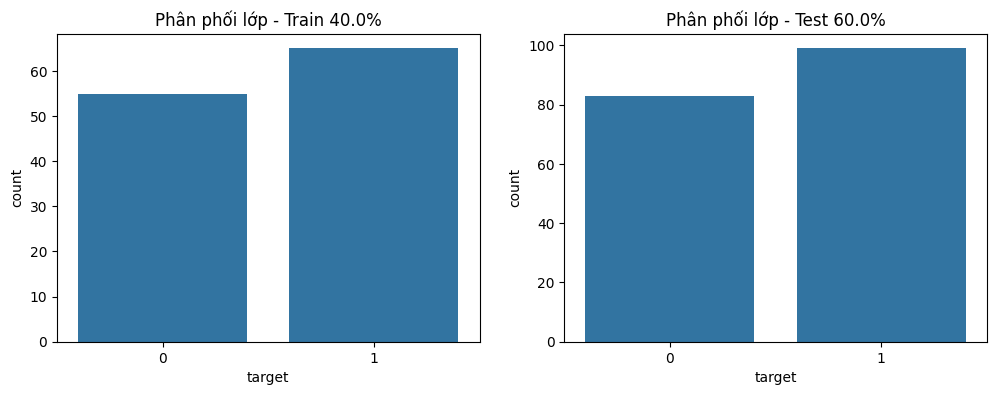


Train/Test 60/40:
Train shape: (181, 13)
Test shape: (121, 13)


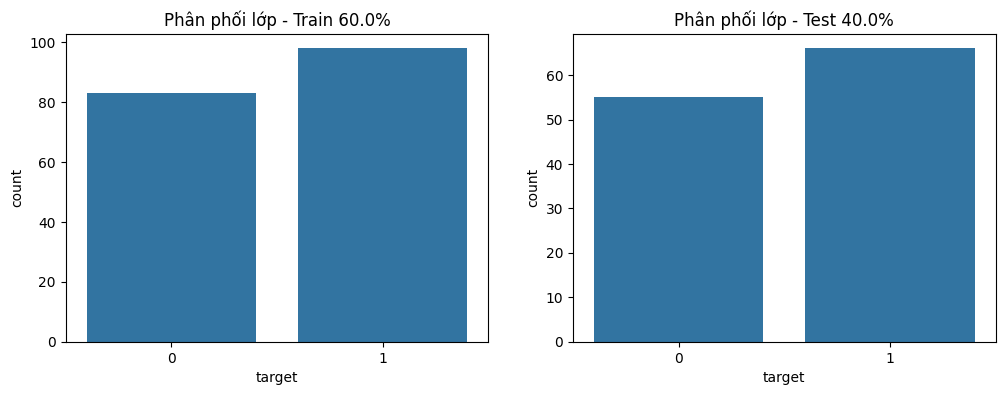


Train/Test 80/20:
Train shape: (241, 13)
Test shape: (61, 13)


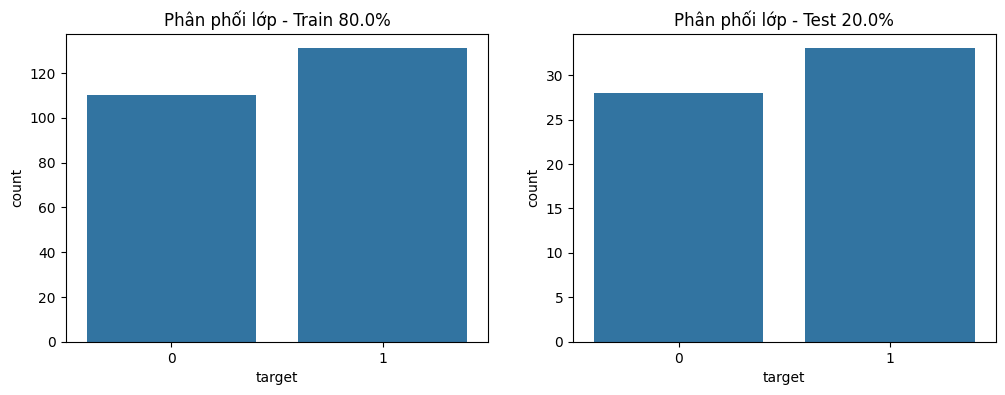


Train/Test 90/10:
Train shape: (271, 13)
Test shape: (31, 13)


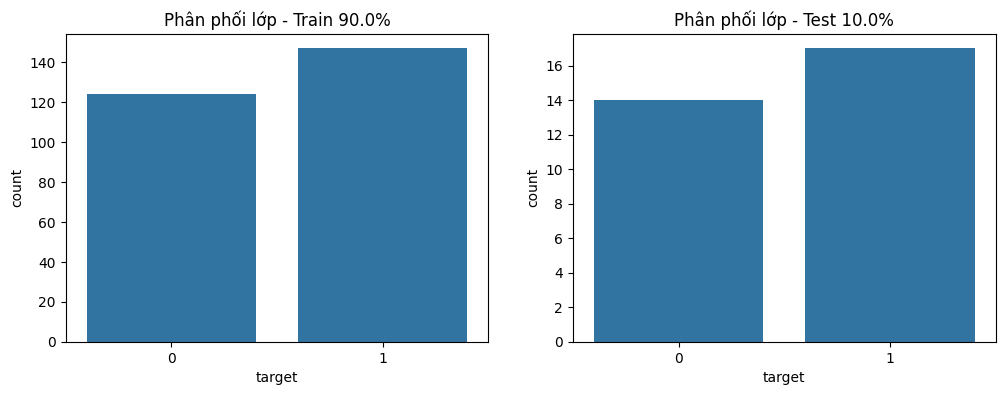


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        28
           1       0.75      0.73      0.74        33

    accuracy                           0.72        61
   macro avg       0.72      0.72      0.72        61
weighted avg       0.72      0.72      0.72        61


Confusion Matrix:
[[20  8]
 [ 9 24]]

Accuracy theo max_depth:
  max_depth  Train Accuracy  Test Accuracy
0      None        1.000000       0.721311
1         2        0.784232       0.655738
2         3        0.838174       0.770492
3         4        0.879668       0.704918
4         5        0.925311       0.721311
5         6        0.954357       0.704918
6         7        0.962656       0.688525


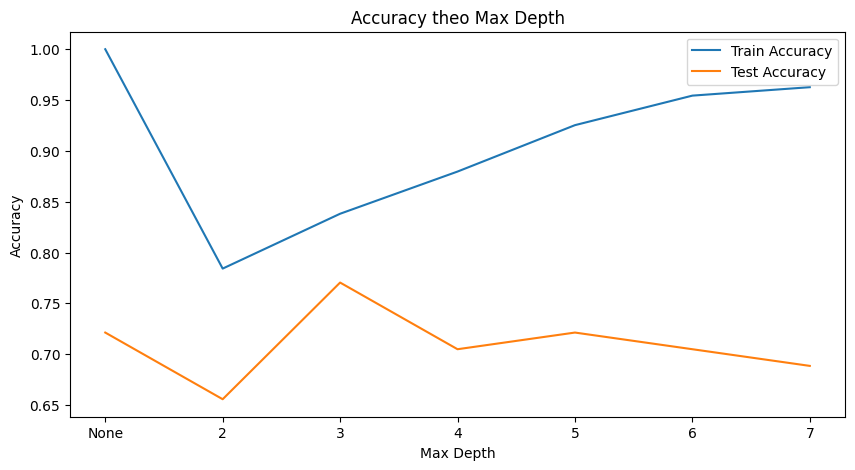

Optimal max_depth = 3, Test Accuracy = 0.7705


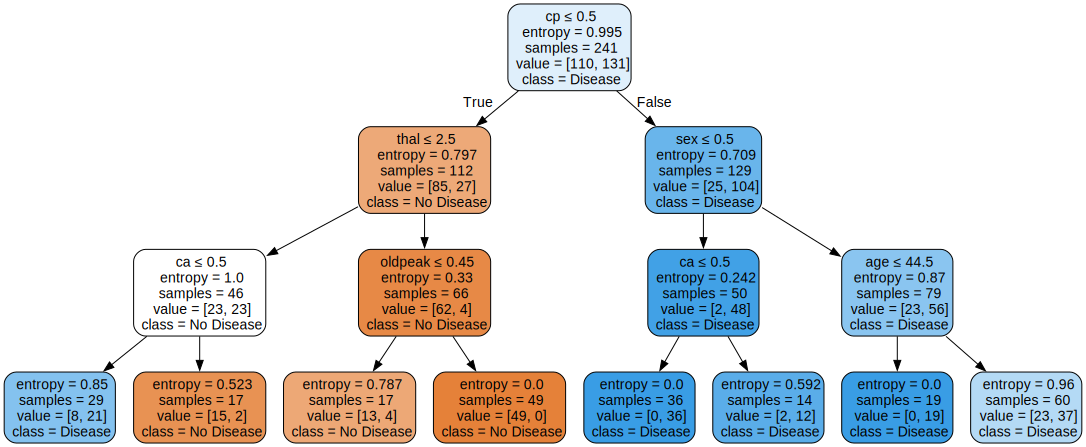

In [13]:


# 2. Chia train/test với các tỉ lệ khác nhau
ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
for train_ratio, test_ratio in ratios:
    X = data.drop('target', axis=1)
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, stratify=y, random_state=42
    )
    print(f"\nTrain/Test {int(train_ratio*100)}/{int(test_ratio*100)}:")
    print("Train shape:", X_train.shape)
    print("Test shape:", X_test.shape)
    
    # Visualize phân phối lớp
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title(f'Phân phối lớp - Train {train_ratio*100}%')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_test)
    plt.title(f'Phân phối lớp - Test {test_ratio*100}%')
    plt.show()

# 3. Train Decision Tree trên tỉ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



# Train model với criterion="entropy"
dt = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt.fit(X_train, y_train)

# Đánh giá model
y_pred = dt.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 4. Khảo sát max_depth
max_depths = [None, 2, 3, 4, 5, 6, 7]
results = []

for depth in max_depths:
    dt = DecisionTreeClassifier(
        criterion="entropy", 
        max_depth=depth, 
        random_state=42
    )
    dt.fit(X_train, y_train)
    train_acc = dt.score(X_train, y_train)
    test_acc = dt.score(X_test, y_test)
    results.append({
        'max_depth': depth if depth is not None else 'None',
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

# Hiển thị kết quả
results_df = pd.DataFrame(results)
print("\nAccuracy theo max_depth:")
print(results_df)

# Visualize kết quả
plt.figure(figsize=(10, 5))
plt.plot(
    results_df['max_depth'].astype(str), 
    results_df['Train Accuracy'], 
    label='Train Accuracy'
)
plt.plot(
    results_df['max_depth'].astype(str), 
    results_df['Test Accuracy'], 
    label='Test Accuracy'
)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy theo Max Depth')
plt.legend()
plt.show()


best_row = results_df.loc[results_df['Test Accuracy'].idxmax()]
best_depth = None if best_row['max_depth']=='None' else int(best_row['max_depth'])
print(f"Optimal max_depth = {best_depth!r}, Test Accuracy = {best_row['Test Accuracy']:.4f}")

# Train lại model với độ sâu tối ưu
dt_opt = DecisionTreeClassifier(criterion="entropy",
                                max_depth=best_depth,
                                random_state=42)
dt_opt.fit(X_train, y_train)

# Export và hiển thị cây
dot_opt = export_graphviz(
    dt_opt,
    out_file=None,
    feature_names=X.columns,
    class_names=['No Disease','Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph_opt = graphviz.Source(dot_opt)
graph_opt.render("id3_tree/heart_disease_tree_opt")  # lưu PDF
graph_opt  # hiển thị trực tiếp trong notebook
